# Trend Youtube

In [115]:
import numpy as np
import pandas as pd
import re
import matplotlib as mpl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col, mode, mean, median
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [116]:
# spark = SparkSession.builder.appName("Youtube Trend").getOrCreate()

# df1 = pd.read_csv('youtube1.csv')
# df2 = pd.read_csv('youtube2.csv')
# df3 = pd.read_csv('youtube3.csv')
# df4 = pd.read_csv('youtube4.csv')
# df5 = pd.read_csv('youtube5.csv')

# merge all dataset
df = pd.concat(
    map(pd.read_csv, ['youtube1.csv', 'youtube2.csv', 'youtube3.csv', 'youtube4.csv', 'youtube5.csv']), 
    ignore_index=True)
print(df)

                                                 Title  \
0    Call of Duty League Major III Tournament | Cha...   
1     I Tried Every Seat on the Most Expensive Airline   
2    Inside the NBA Reacts To Timberwolves Stunning...   
3                      I protected a LEGO PRESIDENT...   
4    #3 TIMBERWOLVES at #2 NUGGETS | FULL GAME 7 HI...   
..                                                 ...   
995  How Sweet - NewJeans ニュージーンズ 뉴진스 [Music Bank] ...   
996                           THE HEART PART 6 - DRAKE   
997  How Did Tim Duncan Agree to This Interview...?...   
998                     fortnite season 3 is broken...   
999  Garnacho & Mainoo Lead United Glory! 🏆 | Man C...   

                                           Description  \
0    Welcome to the #CDL2024 Major III Tournament! ...   
1    I owed a guy a favor\nsign up for shopify for ...   
2    Watch highlights from Inside the NBA with Shaq...   
3    Submit a banger video idea here: https://forms...   
4    Never mi

In [117]:
# Null Count for the entire Dataset
print("Null Count for all Data")
print(df.isnull().sum().sum())
print("")

# Null Count for spesific column
print("Null count for every column")
print(df.isna().sum())
print("")

# Unique count
unique_count = df.nunique()
print("Unique Count")
print(unique_count)
print("")

# Duplicate Rows
duplicate_rows = df.duplicated().sum().sum()
print("Duplicated Rows")
print(duplicate_rows)
print("")

# Drop duplicate row
df = df.drop_duplicates().reset_index()

# Deleting Null Contains Rows and re-index entire dataset
df = df.dropna().reset_index()
df = df.drop(columns=['index'])
print(df)

Null Count for all Data
28

Null count for every column
Title           0
Description    28
Thumbnail       0
dtype: int64

Unique Count
Title          708
Description    682
Thumbnail      706
dtype: int64

Duplicated Rows
285

     level_0                                              Title  \
0          0  Call of Duty League Major III Tournament | Cha...   
1          1   I Tried Every Seat on the Most Expensive Airline   
2          2  Inside the NBA Reacts To Timberwolves Stunning...   
3          3                    I protected a LEGO PRESIDENT...   
4          4  #3 TIMBERWOLVES at #2 NUGGETS | FULL GAME 7 HI...   
..       ...                                                ...   
692      710                              0.001% CAN DO THIS...   
693      711          UFC 302 Embedded: Vlog Series - Episode 2   
694      712           I Bought The Most Expensive Plane Ticket   
695      713         Testing My Off-Road Corvette On Sand dunes   
696      714  CENTRAL CEE FT. LIL 

In [118]:
print(df.describe())

          level_0
count  697.000000
mean   357.746055
std    207.272455
min      0.000000
25%    181.000000
50%    357.000000
75%    538.000000
max    714.000000


<Axes: >

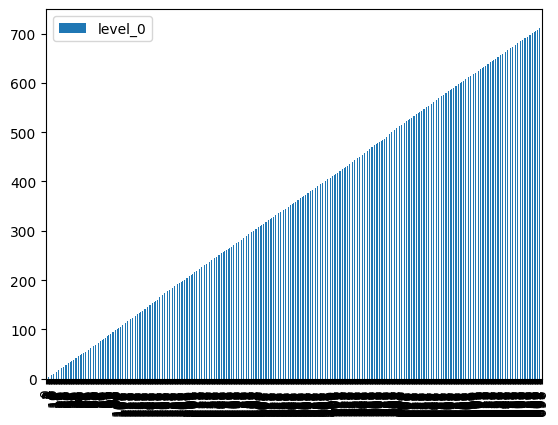

In [119]:
df.plot(kind='bar')

In [120]:
def create_title_sentence(row):
    # Handle multiple cuisines
    title = row['Title']
    if pd.isnull(title):  # Check if cuisines is null
        title = ""
    else:
        title = ' '.join(re.split('[|,;:.!?-]', title))
        # title = ' '.join(title.split('-'))
        # title = ' '.join(title.split('|'))
        
    
    # Return the sentence
    return f"Title: {title}"

# Apply the function to create a new column 'cuisine_sentence' in chefmozcuisine
df['title_sentences'] = df.apply(create_title_sentence, axis=1)
print(df['title_sentences'])

0      Title: Call of Duty League Major III Tournamen...
1      Title: I Tried Every Seat on the Most Expensiv...
2      Title: Inside the NBA Reacts To Timberwolves S...
3                 Title: I protected a LEGO PRESIDENT   
4      Title: #3 TIMBERWOLVES at #2 NUGGETS   FULL GA...
                             ...                        
692                         Title: 0 001% CAN DO THIS   
693     Title: UFC 302 Embedded  Vlog Series   Episode 2
694      Title: I Bought The Most Expensive Plane Ticket
695    Title: Testing My Off Road Corvette On Sand dunes
696    Title: CENTRAL CEE FT  LIL BABY   BAND4BAND (M...
Name: title_sentences, Length: 697, dtype: object


In [121]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
vectorizer = TfidfVectorizer(stop_words=stopwords.words('indonesian'))
tfidf_matrix = vectorizer.fit_transform(df['Title'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

c:\Users\daven\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


In [122]:
# Membuat dictionary untuk menyimpan judul-judul yang mirip
title_similarities = {}

# Membuat loop untuk setiap judul
for idx1 in range(len(df)):
    for idx2 in range(idx1 + 1, len(df)):
        # Hitung cosine similarity antara judul idx1 dan idx2
        similarity = cosine_similarities[idx1, idx2]
        
        # Jika cosine similarity lebih besar dari 0.5, maka judul-judul tersebut mirip
        if similarity > 0.1:
            # Simpan judul-judul yang mirip ke dalam dictionary
            if idx1 not in title_similarities:
                title_similarities[idx1] = []
            title_similarities[idx1].append(idx2)

# Membuat fungsi untuk membuat rekomendasi judul
def get_recommendations(title_idx):
    # Ambil judul-judul yang mirip dengan judul idx
    similar_titles = title_similarities.get(title_idx, [])
    
    # Membuat list untuk menyimpan judul-judul rekomendasi
    recommendations = []
    
    # Loop untuk setiap judul yang mirip
    for similar_title in similar_titles:
        # Tambahkan judul-judul rekomendasi ke dalam list
        recommendations.append(df.loc[similar_title, 'Title'])
    
    # Kembalikan judul-judul rekomendasi
    return recommendations

# Contoh penggunaan fungsi get_recommendations
title_idx = 1  # Ganti dengan indeks judul yang ingin di-rekomendasikan
recommendations = get_recommendations(title_idx)
print(f'Selected Title {df.loc[title_idx, "Title"]}')
for i, recommendation in enumerate(recommendations):
    print(f"Rekomendasi {i+1}: {recommendation}")

Selected Title I Tried Every Seat on the Most Expensive Airline
Rekomendasi 1: I Accidentally Photographed Something Unknown During the Eclipse - Smarter Every Day 298
Rekomendasi 2: I Tried The Best Sandwich In America
Rekomendasi 3: I Mixed Every Dog Treat Into One Piece
Rekomendasi 4: I bought the most MINIMALIST Tech ever.
Rekomendasi 5: Bridgerton Cast vs. 'The Most Impossible Bridgerton Quiz'
Rekomendasi 6: 24 Hours to Catch Every Gen 2 Shiny Pokemon
Rekomendasi 7: I Built Minecraft’s Most Hidden Bases
Rekomendasi 8: Yellowstone’s Most Intense Confrontations ✋ Paramount Network
Rekomendasi 9: Every Kind of Bridge Explained in 15 Minutes
Rekomendasi 10: I Tried Making Homemade Zebra Cakes | Claire Recreates
Rekomendasi 11: The Most Hated Umpire Ever Isn’t Actually Bad
Rekomendasi 12: I tried to live like the World's Strongest Man  //  24 hours with  Eddie Hall
Rekomendasi 13: I played EVERY Arthur Flash game EVER Made - PBG
Rekomendasi 14: I Brutally Rated EVERY YouTuber Product!
